In [1]:
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import random
import numpy as np

from sklearn.metrics.pairwise import euclidean_distances

In [ ]:

class Clustering():
    # taken from scikit-learn (https://goo.gl/1RYPP5)

    @classmethod
    def initialize_centroids(cls, X, k, method="random"):
        if method == 'random':
            ids = list(range(len(X)))
            random.shuffle(ids)
            return [X[i] for i in ids[:k]]

        elif method == 'kmpp':
            chances = [1] * len(X)
            centers = []

            for _ in range(k):
                chances = [x / sum(chances) for x in chances]
                r = random.random()
                acc = 0.0
                for index, chance in enumerate(chances):
                    if acc + chance >= r:
                        break
                    acc += chance
                centers.append(X[index])

                for index, point in tqdm(enumerate(X), desc="scan all points", total=len(X)):
                    distances = [euclidean_distances(center, point) for center in centers]
                    cids = sorted(range(len(distances)), key=lambda x: distances[x])
                    chances[index] = distances[cids[0]]

            return centers

    @classmethod
    def calculate_tolerance(cls, tol, X):
        n = len(X)
        dim = len(X[0])
        averages = [sum(X[i][d] for i in range(n)) / float(n) for d in range(dim)]
        variances = [sum((X[i][d] - averages[d]) ** 2 for i in range(n)) / float(n) for d in range(dim)]
        return tol * sum(variances) / dim

class CopKMean(Clustering):

    @classmethod
    def fit_transform(cls, X, k, must_link=None, cannot_link=None, initialization='random', max_iter=300, tol=1e-4, verbose=False):
        """ Constrained K-Means Algorithm

        Example:
            must_link = {0: {1}, 1: {0}, 3: {4}, 4: {3}}
            cannot_link = {0: {2}}

        """
        must_link = dict() if must_link is None else must_link
        cannot_link = dict() if cannot_link is None else cannot_link

        tol = cls.calculate_tolerance(tol, X)

        if verbose:
            print("initializing centroids...")

        centroids = cls.initialize_centroids(X, k, initialization)
        cluster_assignments = np.zeros(X.shape[0], dtype=int)

        for _ in tqdm(range(max_iter), desc="iterations"):
            cluster_assignments = cls.assign_clusters_constrained(X, centroids, must_link, cannot_link)

            # Update centroids
            new_centroids = cls.update_centroids(X, cluster_assignments, k)

            # Check for convergence based on centroids shift
            shift = sum(euclidean_distances([new_centroids[i]], [centroids[i]])[0, 0] for i in range(k))
            if verbose:
                print("updated centroids with total distance as: {:.3}/{:.3}".format(shift, tol))
            if shift <= tol:
                break

            centroids = new_centroids

        return cluster_assignments, centroids

    @classmethod
    def assign_clusters_constrained(cls, X, centroids, must_link, cannot_link):
        """
        Assign clusters with respect to must-link and cannot-link constraints.

        Parameters:
        X (numpy.ndarray): Data points.
        centroids (numpy.ndarray): Current centroids.
        must_link (dict): Dictionary of must-link constraints.
        cannot_link (dict): Dictionary of cannot-link constraints.

        Returns:
        numpy.ndarray: Cluster assignments.
        """
        n_samples = X.shape[0]
        assignments = np.zeros(n_samples, dtype=int)

        # Calculate distances between each point and each centroid
        distances = euclidean_distances(X, centroids)

        for i in tqdm(range(n_samples), desc="scan samples"):
            # Find the closest centroid
            closest_centroids = np.argsort(distances[i])

            for centroid_index in closest_centroids:
                can_assign = True

                # Check must-link constraints
                if i in must_link:
                    linked_points = must_link[i]
                    if not all(assignments[j] == centroid_index or assignments[j] == 0 for j in linked_points):
                        can_assign = False

                # Check cannot-link constraints
                if can_assign and i in cannot_link:
                    linked_points = cannot_link[i]
                    if any(assignments[j] == centroid_index for j in linked_points):
                        can_assign = False

                # Assign to the closest valid centroid
                if can_assign:
                    assignments[i] = centroid_index
                    break

        return assignments

    @classmethod
    def update_centroids(cls, X, assignments, k):
        """ Update centroids based on current cluster assignments """
        n_features = X.shape[1]
        centroids = np.zeros((k, n_features))

        for cluster_idx in range(k):
            cluster_points = X[assignments == cluster_idx]
            if len(cluster_points) > 0:
                centroids[cluster_idx] = np.mean(cluster_points, axis=0)

        return centroids



In [137]:

class CopKMean_Behrouz(Clustering):
    # from https://github.com/Behrouz-Babaki/COP-Kmeans/blob/master/copkmeans/cop_kmeans.py

    @classmethod
    def fit_transform(cls, X, k, must_link=None, cannot_link=None, initialization='kmpp', max_iter=300, tol=1e-4):
        """

        :param X:
        :param k:
        :param must_link:
        :param cannot_link:
        :param initialization:
        :param max_iter:
        :param tol:
        :return:
        """
        # Convert constraint lists to dictionaries and resolve transitive closure
        must_link = dict() if must_link is None else must_link
        cannot_link = dict() if cannot_link is None else cannot_link
        must_link_info = cls.get_must_link_info(must_link, X)

        # Calculate tolerance for convergence
        tol = cls.calculate_tolerance(tol, X)

        # Initialize centroids based on the chosen method
        centroids = cls.initialize_centroids(X, k, initialization)

        for _ in tqdm(range(max_iter), desc="iterations"):
            # Initialize cluster assignments
            cluster_assignments = [-1] * len(X)

            for i, data_point in tqdm(enumerate(X), total=len(X), desc="scan samples"):
                # Calculate distances from the data point to each centroid
                distances = [euclidean_distances(center, data_point) for center in centroids]
                # Get indices of centroids sorted by distance
                closest_indices = sorted(range(len(distances)), key=lambda x: distances[x])
                counter = 0

                if cluster_assignments[i] == -1:
                    cluster_found = False
                    while (not cluster_found) and counter < len(closest_indices):
                        cluster_idx = closest_indices[counter]
                        # Check if assigning to this cluster violates any constraint
                        if not cls.check_violations(i, cluster_idx, cluster_assignments, must_link, cannot_link):
                            cluster_found = True
                            cluster_assignments[i] = cluster_idx
                            # Assign linked points to the same cluster
                            for linked_idx in must_link[i]:
                                cluster_assignments[linked_idx] = cluster_idx
                        counter += 1

                    # If no cluster found that doesn't violate constraints, return failure
                    if not cluster_found:
                        return None, None

            # Calculate new centroids and check for convergence
            cluster_assignments, new_centroids = cls.assign_clusters_constrained(cluster_assignments, X, k,
                                                                                 must_link_info)
            shift = sum(euclidean_distances([new_centroids[i]], [centroids[i]])[0, 0] for i in range(k))
            # Break loop if centroids shift is within tolerance
            if shift <= tol:
                break
            centroids = new_centroids

        return cluster_assignments, centroids

    @classmethod
    def assign_clusters_constrained(cls, clusters, X, k, ml_info):
        cluster_ids = set(clusters)
        k_new = len(cluster_ids)
        id_map = dict(zip(cluster_ids, range(k_new)))
        clusters = [id_map[x] for x in clusters]

        dim = len(X[0])
        centers = [[0.0] * dim for i in range(k)]

        counts = [0] * k_new
        for j, c in enumerate(clusters):
            for i in range(dim):
                centers[c][i] += X[j][i]
            counts[c] += 1

        for j in range(k_new):
            for i in range(dim):
                centers[j][i] = centers[j][i] / float(counts[j])

        if k_new < k:
            ml_groups, ml_scores, ml_centroids = ml_info
            current_scores = [sum(euclidean_distances(centers[clusters[i]], X[i])
                                  for i in group)
                              for group in ml_groups]
            group_ids = sorted(range(len(ml_groups)),
                               key=lambda x: current_scores[x] - ml_scores[x],
                               reverse=True)

            for j in range(k - k_new):
                gid = group_ids[j]
                cid = k_new + j
                centers[cid] = ml_centroids[gid]
                for i in ml_groups[gid]:
                    clusters[i] = cid

        return clusters, centers

    # taken from scikit-learn (https://goo.gl/1RYPP5)
    @classmethod
    def check_violations(cls, data_index, cluster_index, cluster_assignments, must_link, cannot_link):
        for i in must_link[data_index]:
            if cluster_assignments[i] != -1 and cluster_assignments[i] != cluster_index:
                return True

        for i in cannot_link[data_index]:
            if cluster_assignments[i] == cluster_index:
                return True

        return False

    @classmethod
    def get_must_link_info(cls, must_link, X):
        flags = [True] * len(X)
        groups = []
        for i in range(len(X)):
            if not flags[i]: continue
            group = list(must_link[i] | {i})
            groups.append(group)
            for j in group:
                flags[j] = False

        dim = len(X[0])
        scores = [0.0] * len(groups)
        centroids = [[0.0] * dim for i in range(len(groups))]

        for j, group in enumerate(groups):
            for d in range(dim):
                for i in group:
                    centroids[j][d] += X[i][d]
                centroids[j][d] /= float(len(group))

        scores = [sum(euclidean_distances(centroids[j], X[i])
                      for i in groups[j])
                  for j in range(len(groups))]

        return groups, scores, centroids


In [60]:
def mnist_data(reshape=False, categorical=True):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0

    if reshape:
        # Reshape data
        x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
        x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
    else:
        x_train = x_train.reshape((x_train.shape[0], -1))
        x_test = x_test.reshape((x_test.shape[0], -1))

    if not categorical:
        # Convert class vectors to binary class matrices
        y_train = to_categorical(y_train, 10)
        y_test = to_categorical(y_test, 10)

    return x_train, y_train, x_test, y_test


In [61]:
def prepare_labeled_data(x_train, y_train, percentage, sort=True):
    """
    Prepare subsets of data with varying percentages of labeled data.

    Parameters:
    x_train (numpy.ndarray): Training data features.
    y_train (numpy.ndarray): Training data labels.
    percentages (list): List of percentages of labeled data.
    sort (bool, optional): Whether to sort labeled_labels along with labeled_data. Default is True.

    Returns:
    dict: A dictionary where keys are percentages and values are tuples of 
          (labeled_data, labeled_labels, unlabeled_data).
    """
    labeled_data_dict = {}
    n_samples = x_train.shape[0]

    n_labeled = int(n_samples * percentage)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    labeled_indices = indices[:n_labeled]
    unlabeled_indices = indices[n_labeled:]

    labeled_data = x_train[labeled_indices, :]
    labeled_labels = y_train[labeled_indices]

    if sort:
        # Sort labeled_labels along with labeled_data
        sorted_indices = np.argsort(labeled_labels)
        labeled_data = labeled_data[sorted_indices, :]
        labeled_labels = labeled_labels[sorted_indices]

        unlabeled_data = x_train[unlabeled_indices, :]

    return labeled_data, labeled_labels, unlabeled_data

In [62]:
def label_to_constraints(label_indices):
    """

    :param label_indices: eg. [0, 0, 0, 1, 1, 2, 2]
    :return: must_link, cannot_link:
         - must_link : ({0: {1, 2}, 1: {0, 2}, 2: {0, 1}, 3: {4}, 4: {3}, 5: {6}, 6: {5}},
         - cannot_link : {
                    0: {3, 4, 5, 6},
                    1: {3, 4, 5, 6},
                    2: {3, 4, 5, 6},
                    3: {0, 1, 2, 5, 6},
                    4: {0, 1, 2, 5, 6},
                    5: {0, 1, 2, 3, 4},
                    6: {0, 1, 2, 3, 4}})
    """
    n = len(label_indices)
    must_link, cannot_link = dict(), dict()

    # create a label_indices_map: {label: (start_index, end_index)}
    label_indices_map = dict()

    start_index = 0
    current_label = label_indices[start_index]
    for i in tqdm(range(n)):
        if label_indices[i] != current_label:
            label_indices_map.update({current_label: (start_index, i)})
            start_index = i
            current_label = label_indices[start_index]
    label_indices_map.update({current_label: (start_index, n)})

    for i in tqdm(range(n)):
        start, end = label_indices_map[label_indices[i]]
        must_link.update({i: {j for j in range(start, end) if i != j}})
        cannot_link.update({i: {j for j in range(start)} | {j for j in range(end, n)}})
    return must_link, cannot_link


In [63]:
    x_train, y_train, x_test, y_test = mnist_data()
    
    print(x_train.shape)
    print(y_train.shape)

(60000, 784)
(60000,)


In [64]:
labeled_data, labeled_labels, unlabeled_data = prepare_labeled_data(x_train, y_train, 0.01)


In [65]:
print(labeled_data.shape)
print(unlabeled_data.shape)


(600, 784)
(59400, 784)


In [66]:
X = np.concatenate((labeled_data, unlabeled_data), axis=0)
must_link, cannot_link = label_to_constraints(labeled_labels)


100%|██████████| 600/600 [00:00<00:00, 19167.39it/s]


In [67]:
print(X.shape)
print(must_link, cannot_link)

(60000, 784)
{0: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58}, 1: {0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58}, 2: {0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58}, 3: {0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58}, 4: {0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,

In [139]:
cluster_assignments, centroids = CopKMean_Behrouz.fit_transform(X, 10, must_link, cannot_link)

KeyError: 600

In [80]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

/home/congyu/anaconda3/envs/congyuAI/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/congyu/anaconda3/envs/congyuAI/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


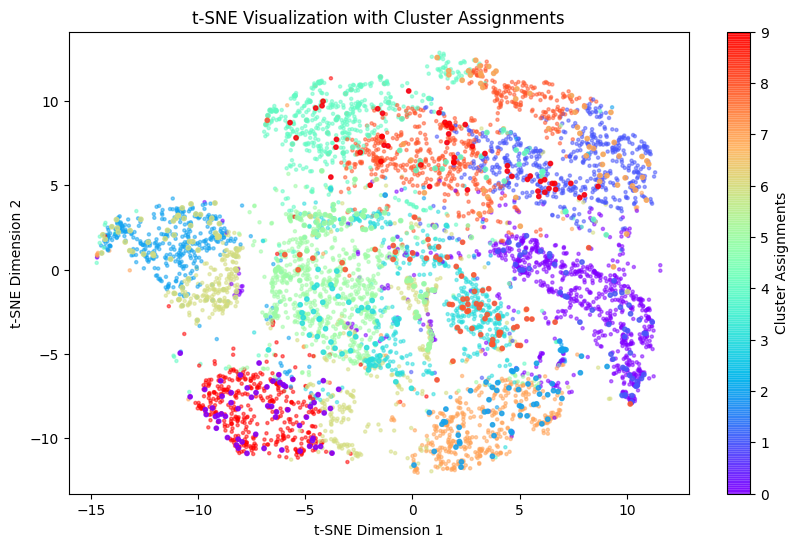

In [91]:
# Create a t-SNE model
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)

# Fit the model to your data (X)
X_tsne = tsne.fit_transform(X[:6000])

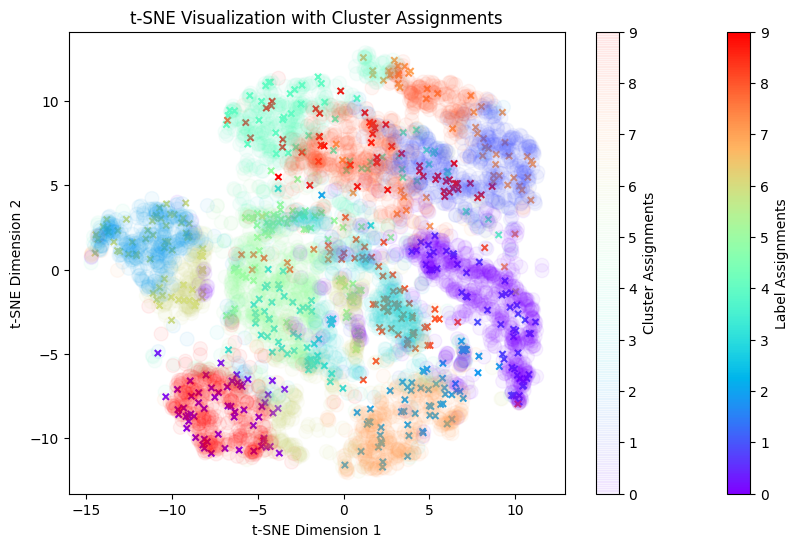

In [136]:

# Scatter plot for all data points with cluster assignments
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:len(labeled_labels), 0], X_tsne[:len(labeled_labels), 1], s=20, c=labeled_labels, cmap='rainbow', marker="x", alpha=1)
plt.colorbar(label='Label Assignments')
plt.scatter(X_tsne[len(labeled_labels):6000, 0], X_tsne[len(labeled_labels):6000, 1], c=cluster_assignments[len(labeled_labels):6000], s=100, cmap='rainbow', alpha=0.05)
plt.colorbar(label='Cluster Assignments')
plt.title('t-SNE Visualization with Cluster Assignments')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()